## Lab 3

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import string
import re
import time
import torch
import typing

In [0]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

Simple flag for manual testing and final run.

In [0]:
DEBUG = False

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [0]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

max length = 63


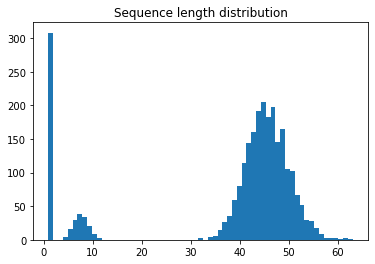

In [5]:
MAX_LENGTH = max(map(len, text))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
hist = plt.hist(list(map(len, text)),bins=MAX_LENGTH)

All lines from text less than 10 characters in length serve as auxiliary information in the source.

In [0]:
def preprocess_text(
    text: typing.List[str], 
    len_thresholds: typing.Tuple[int, int]=(30, MAX_LENGTH),
    blacklist: str=string.digits+string.punctuation
) -> str:
    from_len, to_len = len_thresholds
    assert from_len <= to_len

    def replace(sentence):
        nonlocal blacklist
        for char in blacklist:
            sentence = sentence.translate({ord(char): None})
        return sentence

    return [
        replace(sentence.lstrip().lower())  
        for sentence in text
        if from_len <= len(sentence) <= to_len
    ]

Filter and transform dataset to the most appropriate form.

In [0]:
text = preprocess_text(text)

Put all the characters, that you've seen in the text, into variable `tokens`.

In [0]:
tokens = set("".join(text))
tokens.add('<pad>') # let use space as <pad> token 
tokens = sorted(list(tokens))
num_tokens = len(tokens)

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [0]:
idx_to_token = dict(list(enumerate(tokens)))

token_to_idx = dict([(token, idx) for idx, token in idx_to_token.items()])

In [10]:
assert len(idx_to_token) == len(token_to_idx), "dictionaries must have same size"

for i in range(max(len(idx_to_token), len(token_to_idx))):
    assert token_to_idx[idx_to_token[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [0]:
PAD_IDX = token_to_idx['<pad>']

In [12]:
token_to_idx

{'\n': 0,
 ' ': 1,
 '<pad>': 2,
 'a': 3,
 'b': 4,
 'c': 5,
 'd': 6,
 'e': 7,
 'f': 8,
 'g': 9,
 'h': 10,
 'i': 11,
 'j': 12,
 'k': 13,
 'l': 14,
 'm': 15,
 'n': 16,
 'o': 17,
 'p': 18,
 'q': 19,
 'r': 20,
 's': 21,
 't': 22,
 'u': 23,
 'v': 24,
 'w': 25,
 'x': 26,
 'y': 27,
 'z': 28}

Let's define simple function for mapping texts w.r.t. valid tokens.

In [0]:
def encode(batch: typing.List[str]) -> np.array:
    global token_to_idx

    def encode_token(tokens: str) -> np.array:
        return np.array([token_to_idx[token] for token in tokens])

    return np.concatenate(list(map(encode_token, batch)))

And the function for compression and stretching to desired length.

In [0]:
def reshape_text(
    text: typing.List[str],
    max_tokens_len: int
):
    joined_text = " ".join(text)
    n_tokens = len(joined_text) // max_tokens_len
    reshaped_text = []
    for i in range(0, n_tokens * max_tokens_len, max_tokens_len):
        reshaped_text.append(joined_text[i:i+max_tokens_len])
    return reshaped_text

In [0]:
def to_matrix(
    text: typing.List[str],
    max_len: int=None,
    pad: int=PAD_IDX,
    dtype: str='int32',
    batch_first: bool=True
) -> torch.tensor:
    """Casts a list of sentences into rnn-digestable matrix"""
    max_len = max_len or max(map(len, text))
    matrix = np.zeros([len(text), max_len], dtype) + pad
    for i in range(len(text)):
        line_ix = encode([text[i]])
        matrix[i, :len(line_ix)] = line_ix
    if not batch_first: # convert [batch, time] into [time, batch]
        matrix = np.transpose(matrix)
    return torch.tensor(matrix, dtype=torch.int64)

In [16]:
from pprint import pprint

# just simple check
pprint(text[:5])
transformed_text = to_matrix(text[:5])
pprint(transformed_text)

assert all([len(transformed_text[0]) == len(transformed_text[i]) for i in range(1, len(transformed_text))])
print("Test transformation is successful!")

['from fairest creatures we desire increase\n',
 'that thereby beautys rose might never die\n',
 'but as the riper should by time decease\n',
 'his tender heir might bear his memory\n',
 'but thou contracted to thine own bright eyes\n']
tensor([[ 8, 20, 17, 15,  1,  8,  3, 11, 20,  7, 21, 22,  1,  5, 20,  7,  3, 22,
         23, 20,  7, 21,  1, 25,  7,  1,  6,  7, 21, 11, 20,  7,  1, 11, 16,  5,
         20,  7,  3, 21,  7,  0,  2,  2,  2],
        [22, 10,  3, 22,  1, 22, 10,  7, 20,  7,  4, 27,  1,  4,  7,  3, 23, 22,
         27, 21,  1, 20, 17, 21,  7,  1, 15, 11,  9, 10, 22,  1, 16,  7, 24,  7,
         20,  1,  6, 11,  7,  0,  2,  2,  2],
        [ 4, 23, 22,  1,  3, 21,  1, 22, 10,  7,  1, 20, 11, 18,  7, 20,  1, 21,
         10, 17, 23, 14,  6,  1,  4, 27,  1, 22, 11, 15,  7,  1,  6,  7,  5,  7,
          3, 21,  7,  0,  2,  2,  2,  2,  2],
        [10, 11, 21,  1, 22,  7, 16,  6,  7, 20,  1, 10,  7, 11, 20,  1, 15, 11,
          9, 10, 22,  1,  4,  7,  3, 20,  1, 10, 11, 21,  

In [0]:
N_EPOCHS_DEBUG = 16
N_EPOCHS_RELEASE = 512
N_EPOCHS = N_EPOCHS_DEBUG if DEBUG else N_EPOCHS_RELEASE

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [0]:
def plot_loss(losses: list, title: str=None):
    fig = plt.figure(figsize=(15, 10))
    if title is not None:
        plt.title(title)
    plt.plot(losses)
    plt.ylabel('Loss')
    plt.xlabel('Epoch #')
    plt.show()

In [0]:
# just from class
class VanillaCharRNN(nn.Module):
   
    def __init__(
        self,
        num_tokens: int=len(tokens),
        embedding_size: int=64,
        rnn_num_units: int=128
    ):
        super(VanillaCharRNN, self).__init__()
        self.rnn_num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn = nn.RNN(embedding_size, rnn_num_units, batch_first=True)
        self.linear = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        out, h_next = self.rnn(x_emb, h_prev)
        logits = self.linear(out)
        return h_next, logits
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(1, batch_size, self.rnn_num_units, requires_grad=True)

In [0]:
# dataset with Shakespeare's poetry is small enough
# to load it fully to memory, so creating custom DataLoader
#is overkill in such case

def rnn_epoch(model, hidden_state, all_batches, batch_size):
    global PAD_IDX
    n_batches = all_batches.shape[0] // batch_size
    loss = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    epoch_loss = 0.0
    for i in range(0, n_batches * batch_size, batch_size):
        batch_ix = all_batches[i:i+batch_size]
        hidden_state, out = model(batch_ix, hidden_state)
        actual_next_tokens = batch_ix[:, 1:]
        batch_loss = loss(out[:, :-1].reshape(-1, len(tokens)), actual_next_tokens.reshape(-1))
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += batch_loss.item()
        hidden_state.detach_()
        hidden_state = hidden_state.detach()
    epoch_loss /= n_batches
    return hidden_state, epoch_loss

In [0]:
def train(
    model: nn.Module,
    n_epochs: int=16,
    optimizer=None,
    max_tokens_len: int=MAX_LENGTH-3,
    batch_size: int=10
):
    epoch_losses = []
    reshaped_text = reshape_text(text, max_tokens_len)
    all_batches = to_matrix(reshaped_text, max_tokens_len)
    hidden_state = model.initial_state(batch_size)
    for epoch in range(n_epochs):
        start_time = time.time()
        hidden_state, epoch_loss = rnn_epoch(model, hidden_state, all_batches, batch_size)
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, n_epochs, time.time() - start_time))
        epoch_losses.append(epoch_loss)
    return epoch_losses, hidden_state

In [0]:
model = VanillaCharRNN()
optimizer = torch.optim.Adam(model.parameters())

In [24]:
epoch_losses, hidden_state = train(model, N_EPOCHS, optimizer)

Epoch 1 of 512 took 1.580s
Epoch 2 of 512 took 1.561s
Epoch 3 of 512 took 1.555s
Epoch 4 of 512 took 1.519s
Epoch 5 of 512 took 1.528s
Epoch 6 of 512 took 1.522s
Epoch 7 of 512 took 1.539s
Epoch 8 of 512 took 1.525s
Epoch 9 of 512 took 1.533s
Epoch 10 of 512 took 1.517s
Epoch 11 of 512 took 1.537s
Epoch 12 of 512 took 1.525s
Epoch 13 of 512 took 1.506s
Epoch 14 of 512 took 1.533s
Epoch 15 of 512 took 1.520s
Epoch 16 of 512 took 1.528s
Epoch 17 of 512 took 1.551s
Epoch 18 of 512 took 1.576s
Epoch 19 of 512 took 1.546s
Epoch 20 of 512 took 1.560s
Epoch 21 of 512 took 1.530s
Epoch 22 of 512 took 1.543s
Epoch 23 of 512 took 1.538s
Epoch 24 of 512 took 1.562s
Epoch 25 of 512 took 1.623s
Epoch 26 of 512 took 1.559s
Epoch 27 of 512 took 1.559s
Epoch 28 of 512 took 1.563s
Epoch 29 of 512 took 1.602s
Epoch 30 of 512 took 1.608s
Epoch 31 of 512 took 1.565s
Epoch 32 of 512 took 1.614s
Epoch 33 of 512 took 1.642s
Epoch 34 of 512 took 1.660s
Epoch 35 of 512 took 1.646s
Epoch 36 of 512 took 1.615s
E

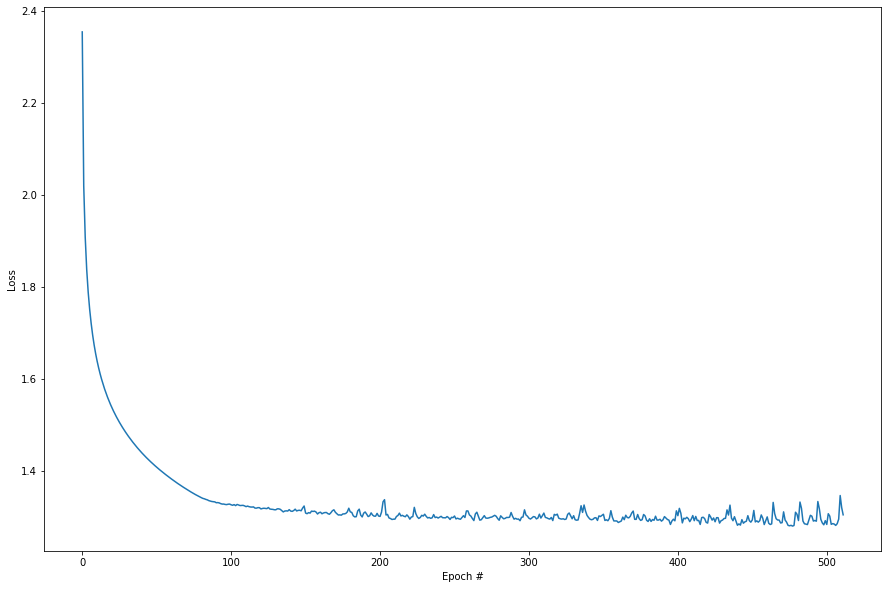

In [25]:
plot_loss(epoch_losses)

Okey, out RNN is training correctly.

In [0]:
def generate_sample(model, seed_phrase=' ', max_length=400, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.long)
    states = model.initial_state(batch_size=1)
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        states, _ = model(x_sequence[:, :, i], states)
    for _ in range(max_length - len(seed_phrase)):
        states, out = model(x_sequence[:,:, -1], states)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0].ravel()
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.long)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

In [27]:
for temperature in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f"\n\tTemperature: {temperature}")
    print(generate_sample(model, seed_phrase="heart", temperature=temperature))


	Temperature: 0.1
heart my love thou art the store
 which i do i am they senese is that i have still the thought to me thee the store
 which i know when i see the store
 which i do i am they senese the world the true self a man is thy self a mark in the fresh thee i see they be false thou art and things in the fair thing and things in the sweet shall thou should make the beauty seem they from the fair that i then f

	Temperature: 0.2
heart
 the world the sweet shall thou should make my part the present forght is art the rank in the face
 then with a seen
 which i briend
 and thou art the store
 which i do i am which the store
 which i may which i may they sing
 and the world the world the true self in the filld and thou wilt thou art the prove
 that they be false in the fresh thee the thought of thy self all my mind
 for they 

	Temperature: 0.5
hearturn should decowiep his such a same
 the thoughts it is not so not shall not still dear
 more in faults in the will eng and make the on 

 As we can see, higher temperature produces more chaotic outputs and smaller temperature converges to the single most likely output.

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [0]:
class LSTMCharRNN(nn.Module):

    def __init__(
        self,
        num_tokens: int=len(tokens),
        embedding_size: int=64,
        rnn_num_units: int=128
    ):
        super(LSTMCharRNN, self).__init__()
        self.rnn_num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(embedding_size, rnn_num_units, batch_first=True)
        self.linear = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, states=None):
        x_emb = self.embedding(x)
        if states is None:
            states = initial_state(1)
        out, states = self.lstm(x_emb, states)
        # hidden_state, cell_state = states
        logits = self.linear(out)
        return states, logits
    
    def initial_state(self, batch_size) -> typing.Tuple[torch.Tensor, torch.Tensor]:
        return (
            torch.zeros(1, batch_size, self.rnn_num_units, requires_grad=True),
            torch.zeros(1, batch_size, self.rnn_num_units, requires_grad=True)
        )

In [0]:
def rnn_epoch_lstm(model, states, all_batches, batch_size):
    global PAD_IDX
    n_batches = all_batches.shape[0] // batch_size
    loss = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    epoch_loss = 0.0
    for i in range(0, n_batches * batch_size, batch_size):
        batch_ix = all_batches[i:i+batch_size]
        states, out = model(batch_ix, states)
        hidden_state, cell_state = states
        actual_next_tokens = batch_ix[:, 1:]
        batch_loss = loss(out[:, :-1].reshape(-1, len(tokens)), actual_next_tokens.reshape(-1))
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += batch_loss.item()
        hidden_state.detach_()
        hidden_state = hidden_state.detach()
        cell_state.detach_()
        cell_state = cell_state.detach()
        states = hidden_state, cell_state
    epoch_loss /= n_batches
    return states, epoch_loss

In [0]:
def train_lstm(
    model: nn.Module,
    n_epochs: int=16,
    optimizer=None,
    max_tokens_len: int=MAX_LENGTH-3,
    batch_size: int=10
):
    epoch_losses = []
    reshaped_text = reshape_text(text, max_tokens_len)
    all_batches = to_matrix(reshaped_text, max_tokens_len)
    states = model.initial_state(batch_size)
    for epoch in range(n_epochs):
        start_time = time.time()
        states, epoch_loss = rnn_epoch_lstm(
            model,
            states,
            all_batches,
            batch_size
        )
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, n_epochs, time.time() - start_time))
        epoch_losses.append(epoch_loss)
    return epoch_losses, states

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [0]:
lstm_model = LSTMCharRNN()
optimizer = torch.optim.Adam(lstm_model.parameters())

Epoch 1 of 512 took 4.051s
Epoch 2 of 512 took 4.247s
Epoch 3 of 512 took 6.188s
Epoch 4 of 512 took 6.004s
Epoch 5 of 512 took 4.077s
Epoch 6 of 512 took 4.091s
Epoch 7 of 512 took 4.012s
Epoch 8 of 512 took 4.066s
Epoch 9 of 512 took 3.964s
Epoch 10 of 512 took 4.018s
Epoch 11 of 512 took 4.001s
Epoch 12 of 512 took 3.967s
Epoch 13 of 512 took 3.963s
Epoch 14 of 512 took 3.985s
Epoch 15 of 512 took 3.975s
Epoch 16 of 512 took 4.022s
Epoch 17 of 512 took 3.966s
Epoch 18 of 512 took 3.978s
Epoch 19 of 512 took 4.022s
Epoch 20 of 512 took 4.005s
Epoch 21 of 512 took 4.014s
Epoch 22 of 512 took 4.010s
Epoch 23 of 512 took 3.987s
Epoch 24 of 512 took 4.018s
Epoch 25 of 512 took 4.074s
Epoch 26 of 512 took 4.040s
Epoch 27 of 512 took 3.999s
Epoch 28 of 512 took 3.923s
Epoch 29 of 512 took 4.008s
Epoch 30 of 512 took 3.959s
Epoch 31 of 512 took 3.997s
Epoch 32 of 512 took 4.027s
Epoch 33 of 512 took 3.985s
Epoch 34 of 512 took 3.989s
Epoch 35 of 512 took 3.960s
Epoch 36 of 512 took 3.977s
E

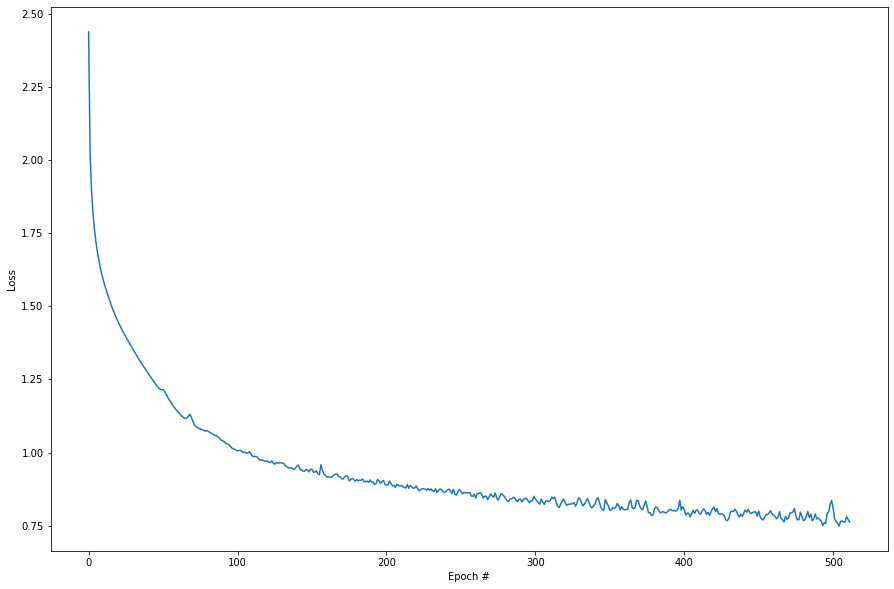

In [32]:
all_losses, states = train_lstm(lstm_model, N_EPOCHS, optimizer)
plot_loss(all_losses)

As expected, `LSTM` reaches better loss.

In [33]:
for temperature in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f"\n\tTemperature: {temperature}")
    print(generate_sample(lstm_model, seed_phrase="heart", temperature=temperature))


	Temperature: 0.1
hearth thee
 the heart and the world oer their state
 but not thy shames in thy beauty befor which now
 all to me not to flatterly
 this thy prowd the thine eyes
 but thou cares and praises breed by the statute of me
 whilst her part so fair sort
 and therefore than were but when they looks his love her etern for my love as thou art
 as those have i as thine own see
 the world with mest
 this thou

	Temperature: 0.2
hearth the state doth be near
 my heart rich i have sworn they are blood
 making a faming to my glutterd me
 if thou shalt fair no prectious not doth that which it fair whereit in my self alone
 that is my heart and therefore to full with beauty so
 had they mistly love thee more that which i compile
 to me fair no more when the world oer despite
 the rank in my mind of blush comments
 the things 

	Temperature: 0.5
hearth thee
 thy loses the worlds me for it wrons falsess that well keen
 but her strange the things their sweet reements true is loss
 that 

Also generated text seems "more poetic". 

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [0]:
# Saving and loading code here
torch.save(lstm_model.state_dict(), 'sonnets_text_gen.pth')

In [35]:
new_lstm_model = LSTMCharRNN()
new_lstm_model.load_state_dict(torch.load('sonnets_text_gen.pth'))
new_lstm_model.eval()

LSTMCharRNN(
  (embedding): Embedding(29, 64, padding_idx=2)
  (lstm): LSTM(64, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=29, bias=True)
)

In [36]:
print(generate_sample(new_lstm_model, max_length=100, temperature=0.75))

 by
 and capther use thee viceis and therefore to be miser
 surece it is not so much her use
 so run


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)

### Conclusion:  
  
To sum up, vanilla `RNN` model was unable to "memoize" a lot of previous information. On the other hand, `LSTM` does not have such problem. Certainly, it also loses the information, but not so much. Moreover, 

### P.S.:  
  
I'm sorry for dublicating the train code for NN. I realized it after refactor and long training and testing both models.